# UATD processing

## Getting the data (if not already done)
OLD CODE, but the data should e unzipped.

Using the UATD dataset:

- Download the dataset from [here](hhttps://figshare.com/articles/dataset/UATD_Dataset/21331143/3). Download all 4 zips.
- Then unzip them manually or running code below:

In [1]:
# import zipfile
# import os

# zip_paths = [ "../data/UATD_Test_1.zip", "../data/UATD_Test_2.zip", "../data/UATD_Training.zip",]
# extract_dir = "../data/UATD/"

# # Make sure the target directory exists
# os.makedirs(extract_dir, exist_ok=True)

# for zip_path in zip_paths:
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_dir)
#     print(zip_path, " extracted to:", os.path.abspath(extract_dir))

## Setup on YOLO format

### Set up the paths

OLD CODE

In [2]:
# # Set up the paths

# from pathlib import Path

# NOT_ROOT = Path.cwd()
# ROOT = NOT_ROOT.parent
# DATA = ROOT / "data" / "UATD"

# UATD_TRAIN = DATA / "UATD_Training"
# UATD_VAL   = DATA / "UATD_Test_1"
# UATD_TEST  = DATA / "UATD_Test_2"

# # YOLO folders directly inside UATD/
# YOLO_IMG = DATA / "images"
# YOLO_LBL = DATA / "labels"

# # Create standard YOLO directory tree
# for split in ["train", "val", "test"]:
#     (YOLO_IMG / split).mkdir(parents=True, exist_ok=True)
#     (YOLO_LBL / split).mkdir(parents=True, exist_ok=True)

# print("✅ YOLO structure ready at:", DATA)


### Convert from XMLs -> YOLO format

OLD CODE!!


In [4]:
# # Convert XMLs → YOLO labels

# import glob, shutil
# from xml.etree import ElementTree as ET

# SPLIT_MAP = {
#     "train": UATD_TRAIN,
#     "val":   UATD_VAL,
#     "test":  UATD_TEST,
# }

# def parse_box(obj):
#     bb = obj.find("bndbox")
#     return (
#         float(bb.findtext("xmin")),
#         float(bb.findtext("ymin")),
#         float(bb.findtext("xmax")),
#         float(bb.findtext("ymax")),
#     )

# def voc_to_yolo(xmin, ymin, xmax, ymax, w, h):
#     cx = ((xmin + xmax) / 2) / w
#     cy = ((ymin + ymax) / 2) / h
#     bw = (xmax - xmin) / w
#     bh = (ymax - ymin) / h
#     return cx, cy, bw, bh

# def sanitize(name: str):
#     return name.strip().replace(" ", "-").lower()

# def convert_to_yolo():
#     class_to_id, classes = {}, []

#     for split, src_dir in SPLIT_MAP.items():
#         ann_dir = src_dir / "annotations"
#         img_dir = src_dir / "images"
#         xmls = sorted(glob.glob(str(ann_dir / "*.xml")))
#         print(f"[{split}] Found {len(xmls)} XMLs")

#         for xml in xmls:
#             root = ET.parse(xml).getroot()
#             w = int(root.find("size").findtext("width"))
#             h = int(root.find("size").findtext("height"))
#             fname = root.find("file").findtext("filename") or Path(xml).stem
#             stem = Path(fname).stem
#             img_src = img_dir / f"{stem}.bmp"

#             if not img_src.exists():
#                 print(f"⚠️ Missing image for {stem}.bmp")
#                 continue

#             # Write YOLO label
#             lbl_path = YOLO_LBL / split / f"{stem}.txt"
#             with open(lbl_path, "w") as y:
#                 for obj in root.findall("object"):
#                     cname = sanitize(obj.findtext("name"))
#                     if cname not in class_to_id:
#                         class_to_id[cname] = len(classes)
#                         classes.append(cname)
#                     cls_id = class_to_id[cname]
#                     xmin, ymin, xmax, ymax = parse_box(obj)
#                     cx, cy, bw, bh = voc_to_yolo(xmin, ymin, xmax, ymax, w, h)
#                     y.write(f"{cls_id} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")

#             # Copy image to YOLO folder
#             dst_img = YOLO_IMG / split / img_src.name
#             if not dst_img.exists():
#                 shutil.copy2(img_src, dst_img)

#     print("✅ Conversion complete.")
#     print("Classes:", classes)
#     return classes

# CLASSES = convert_to_yolo()


## Labels validation


### Check validity

OLD CODE, some images were invalid and removed

Here we check if the BB and classes are valid.

In [4]:
# # check if valid:
# #!/usr/bin/env python3
# # check_yolo_annotations.py
# #
# # Validate YOLO labels under data/UATD/{images,labels}/{train,val,test}.
# # Reports missing pairs and per-line label errors.

# from pathlib import Path
# import glob

# DATA_ROOT = Path("../data/UATD")
# SPLITS = ["train", "val", "test"]
# NUM_CLASSES = 10
# EPS = 1e-9

# def list_stems(dirpath: Path, pattern: str):
#     return {Path(p).stem for p in glob.glob(str(dirpath / pattern))}

# def validate_line(parts, split, stem, lineno):
#     """Return None if ok, else an error string."""
#     if len(parts) < 5:
#         return f"[{split}] {stem}.txt:{lineno}: expected 5 values 'cls cx cy w h', got {len(parts)}"

#     # parse values
#     try:
#         cls = int(float(parts[0]))
#         cx, cy, w, h = map(float, parts[1:5])
#     except Exception as e:
#         return f"[{split}] {stem}.txt:{lineno}: parse error: {e}"

#     # class check
#     if not (0 <= cls < NUM_CLASSES):
#         return f"[{split}] {stem}.txt:{lineno}: class {cls} not in [0..{NUM_CLASSES-1}]"

#     # bounds checks (YOLO normalized)
#     if not (0.0 <= cx <= 1.0) or not (0.0 <= cy <= 1.0):
#         return f"[{split}] {stem}.txt:{lineno}: center out of range (cx={cx:.6f}, cy={cy:.6f})"

#     # width/height correspond to (xmax-xmin)/W and (ymax-ymin)/H
#     if not (w > EPS and h > EPS):
#         return f"[{split}] {stem}.txt:{lineno}: non-positive box size (w={w:.6f}, h={h:.6f})"
#     if w > 1.0 or h > 1.0:
#         return f"[{split}] {stem}.txt:{lineno}: box size exceeds 1.0 (w={w:.6f}, h={h:.6f})"

#     return None

# def main():
#     total_invalid = 0
#     total_missing_img = 0
#     total_missing_lbl = 0

#     for split in SPLITS:
#         img_dir = DATA_ROOT / "images" / split
#         lbl_dir = DATA_ROOT / "labels" / split

#         # basic presence
#         if not img_dir.exists() or not lbl_dir.exists():
#             print(f"[{split}] missing folder(s): images={img_dir.exists()} labels={lbl_dir.exists()}")
#             continue

#         imgs = list_stems(img_dir, "*.*")
#         lbls = list_stems(lbl_dir, "*.txt")

#         # pair checks
#         miss_img = sorted(lbls - imgs)
#         miss_lbl = sorted(imgs - lbls)

#         for s in miss_img:
#             print(f"[{split}] missing image for label: {s}.txt → expected in {img_dir}")
#         for s in miss_lbl:
#             print(f"[{split}] missing label for image: {s}.* → expected {lbl_dir}/{s}.txt")

#         total_missing_img += len(miss_img)
#         total_missing_lbl += len(miss_lbl)

#         # label content checks
#         invalid = 0
#         for stem in sorted(lbls & imgs):  # only those that have both
#             path = lbl_dir / f"{stem}.txt"
#             try:
#                 with open(path, "r") as f:
#                     for i, line in enumerate(f, 1):
#                         line = line.strip()
#                         if not line:
#                             # empty lines are invalid for YOLO format
#                             print(f"[{split}] {stem}.txt:{i}: empty line")
#                             invalid += 1
#                             continue
#                         parts = line.split()
#                         err = validate_line(parts, split, stem, i)
#                         if err:
#                             print(err)
#                             invalid += 1
#             except Exception as e:
#                 print(f"[{split}] {stem}.txt: unable to read: {e}")
#                 invalid += 1

#         total_invalid += invalid
#         print(f"[{split}] summary → invalid lines: {invalid}, missing images: {len(miss_img)}, missing labels: {len(miss_lbl)}")

#     print("-" * 60)
#     print(f"TOTAL invalid lines: {total_invalid}")
#     print(f"TOTAL missing images for labels: {total_missing_img}")
#     print(f"TOTAL missing labels for images: {total_missing_lbl}")

# if __name__ == "__main__":
#     main()


### (Optinal) Remove invalid images

OLD CODE

The dataset seems to have some invalid instances as seen above. These images are removed entirely from the dataset. This is optional.

In [5]:
# #!/usr/bin/env python3
# # cleanup_invalid_yolo.py
# #
# # Removes any image + label pair that fails basic YOLO validity checks.
# # - Deletes files with invalid label lines (bad class, bad coords, empty lines)
# # - Deletes orphan images or orphan labels
# # - Prints a full summary of removed files

# from pathlib import Path
# import glob
# import os

# DATA_ROOT = Path("../data/UATD")
# SPLITS = ["train", "val", "test"]
# NUM_CLASSES = 10
# EPS = 1e-9


# def list_stems(dirpath: Path, pattern: str):
#     return {Path(p).stem for p in glob.glob(str(dirpath / pattern))}


# def label_has_error(lbl_path: Path):
#     """Return True if label has any invalid lines."""
#     try:
#         with open(lbl_path, "r") as f:
#             lines = [l.strip() for l in f if l.strip()]
#         if not lines:
#             return True
#         for i, line in enumerate(lines, 1):
#             parts = line.split()
#             if len(parts) < 5:
#                 return True
#             try:
#                 cls = int(float(parts[0]))
#                 cx, cy, w, h = map(float, parts[1:5])
#             except Exception:
#                 return True
#             if not (0 <= cls < NUM_CLASSES):
#                 return True
#             if not (0 <= cx <= 1 and 0 <= cy <= 1):
#                 return True
#             if not (w > EPS and h > EPS and w <= 1.0 and h <= 1.0):
#                 return True
#     except Exception:
#         return True
#     return False


# def safe_remove(path: Path):
#     if path.exists():
#         path.unlink()
#         print(f"🗑️ Removed {path}")


# def main():
#     total_removed = 0
#     for split in SPLITS:
#         img_dir = DATA_ROOT / "images" / split
#         lbl_dir = DATA_ROOT / "labels" / split
#         if not img_dir.exists() or not lbl_dir.exists():
#             print(f"[{split}] missing images/labels folder — skipping")
#             continue

#         imgs = list_stems(img_dir, "*.*")
#         lbls = list_stems(lbl_dir, "*.txt")

#         # Orphan labels (no image)
#         for s in sorted(lbls - imgs):
#             lbl_path = lbl_dir / f"{s}.txt"
#             safe_remove(lbl_path)
#             total_removed += 1

#         # Orphan images (no label)
#         for s in sorted(imgs - lbls):
#             for ext in [".bmp", ".jpg", ".png", ".jpeg"]:
#                 img_path = img_dir / f"{s}{ext}"
#                 if img_path.exists():
#                     safe_remove(img_path)
#                     total_removed += 1
#                     break

#         # Check each label and remove invalid ones (and its image)
#         for s in sorted(lbls & imgs):
#             lbl_path = lbl_dir / f"{s}.txt"
#             if label_has_error(lbl_path):
#                 # remove label + all possible image extensions
#                 safe_remove(lbl_path)
#                 for ext in [".bmp", ".jpg", ".png", ".jpeg"]:
#                     img_path = img_dir / f"{s}{ext}"
#                     if img_path.exists():
#                         safe_remove(img_path)
#                         break
#                 total_removed += 1

#     print("------------------------------------------------")
#     print(f"✅ Cleanup complete. Total removed image/label pairs: {total_removed}")


# if __name__ == "__main__":
#     main()


## Make the config file

In [6]:
from pathlib import Path

UATD_ROOT = Path.cwd()             

DATA = UATD_ROOT / "processed" 
IMAGES_TRAIN = DATA / "images" / "train"
IMAGES_VAL = DATA / "images" / "val"
IMAGES_TEST   = DATA / "images" / "test"        # or use a dedicated val split if you have one

dataset_yaml = f"""
train: {IMAGES_TRAIN.as_posix()}
val:   {IMAGES_VAL.as_posix()}
test:  {IMAGES_TEST.as_posix()}

# UATD has 10 classes
names:
  - human-body
  - ball
  - circle-cage
  - square-cage
  - tyre
  - metal-bucket
  - cube
  - cylinder
  - plane
  - rov
"""


(UATD_ROOT / "uatd.yaml").write_text(dataset_yaml)
print("Wrote:", UATD_ROOT / "uatd.yaml")




Wrote: /cluster/home/henrban/aquaculture-perception/data-processing/sonar/UATD/uatd.yaml


## Dataset summary

Note that summary of dataset (class distribution etc) can be seen when training yolo in outputs/.

In [7]:
from pathlib import Path
import sys

DATA_PROCESSING_ROOT = Path.cwd().resolve().parents[1] 
sys.path.insert(0, str(DATA_PROCESSING_ROOT))

from utils.yolo_dataset_summary import count_from_yaml

counts = count_from_yaml("uatd.yaml")
# print(counts)
for split in ["train", "val", "test", "total"]:
    if split in counts:
        print(f"{split:5s}  images={counts[split]['images']:6d}  instances={counts[split]['instances']:8d}")


train  images=  7589  instances=   12287
val    images=   798  instances=    1169
test   images=   798  instances=    1154
total  images=  9185  instances=   14610


## Dataset examples

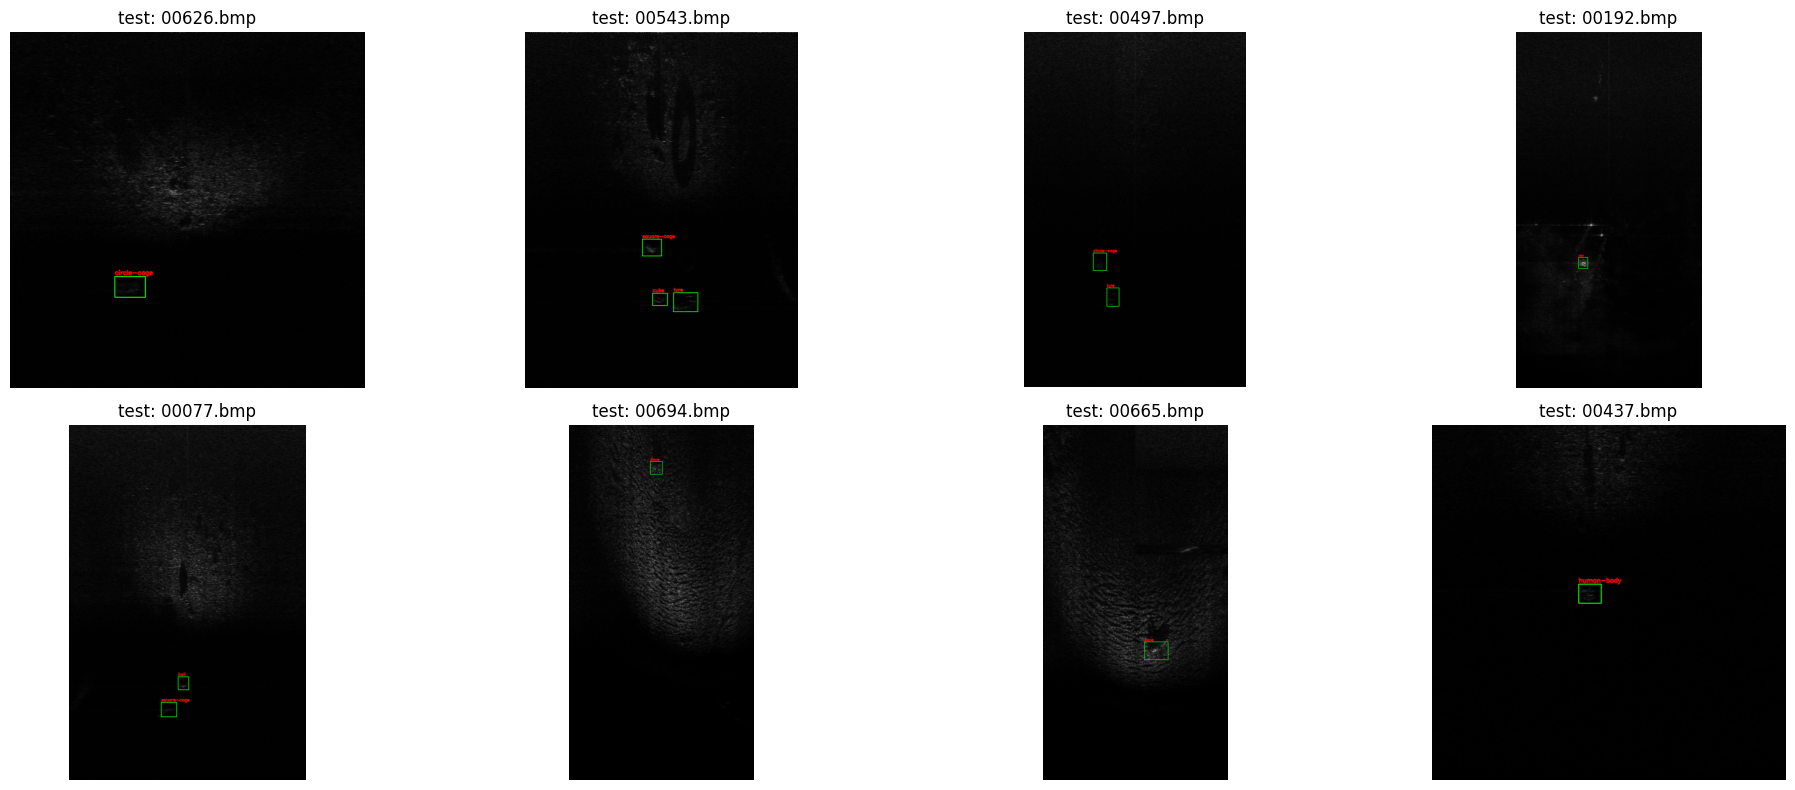

In [ ]:
from pathlib import Path
import sys

DATA_PROCESSING_ROOT = Path.cwd().resolve().parents[1] 
sys.path.insert(0, str(DATA_PROCESSING_ROOT))


from utils.yolo_viz import load_yolo_dataset_yaml, show_random_labeled_images

ds = load_yolo_dataset_yaml("uatd.yaml")  # yaml is next to the notebook

split = "test"  # train / val / test
img_dir = {"train": ds.train, "val": ds.val, "test": ds.test}[split]

show_random_labeled_images(
    images_split_dir=img_dir,
    names=ds.names,
    num_pics=8,
    cols=4,
    require_labels=True,
    seed=0,
    title_prefix=f"{split}: ",
)


In [9]:
## OLD CODE TO CHECK SPESIFIC IMAGES


# # ============================================================
# # Visualize a specific YOLO-annotated image
# # ============================================================
# import cv2
# import matplotlib.pyplot as plt
# from pathlib import Path
# import re
# import yaml

# # ---------------- Configuration ----------------
# DATA_ROOT = Path("../data/UATD")
# IMG_DIR = DATA_ROOT / "images"
# LAB_DIR = DATA_ROOT / "labels"

# SPLIT = "train"        # "train", "val", or "test"
# IMAGE_NAME = "00402.bmp"   # <-- change this to your file

# # Optional: read names from data/UATD/uatd.yaml
# yaml_path = DATA_ROOT / "uatd.yaml"
# if yaml_path.exists():
#     try:
#         y = yaml.safe_load(yaml_path.read_text())
#         if isinstance(y.get("names"), list):
#             NAMES = y["names"]
#         elif isinstance(y.get("names"), dict):
#             NAMES = [name for _, name in sorted(y["names"].items(), key=lambda kv: int(kv[0]))]
#         else:
#             NAMES = None
#     except Exception:
#         NAMES = None
# else:
#     NAMES = None

# # Fallback to default UATD names
# if not NAMES:
#     NAMES = [
#         "human-body", "ball", "circle-cage", "square-cage", "tyre",
#         "metal-bucket", "cube", "cylinder", "plane", "rov",
#     ]
# # ------------------------------------------------


# def draw_yolo_labels(image_bgr, label_file: Path, names):
#     """Draw YOLO labels (cx, cy, w, h) on the given image."""
#     img = image_bgr.copy()
#     h, w = img.shape[:2]
#     if not label_file.exists():
#         print(f"⚠️ No label file found: {label_file}")
#         return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     for line in label_file.read_text().splitlines():
#         line = line.strip()
#         if not line:
#             continue
#         parts = re.split(r"\s+", line)
#         if len(parts) < 5:
#             continue
#         cls = int(float(parts[0]))
#         cx, cy, bw, bh = map(float, parts[1:5])

#         # Convert normalized YOLO → pixel coordinates
#         x1 = int((cx - bw / 2) * w)
#         y1 = int((cy - bh / 2) * h)
#         x2 = int((cx + bw / 2) * w)
#         y2 = int((cy + bh / 2) * h)

#         # Clamp to image bounds
#         x1 = max(0, min(w - 1, x1))
#         y1 = max(0, min(h - 1, y1))
#         x2 = max(0, min(w - 1, x2))
#         y2 = max(0, min(h - 1, y2))

#         color = (0, 255, 0)  # green box
#         cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

#         label = names[cls] if 0 <= cls < len(names) else f"id{cls}"
#         cv2.putText(img, label, (x1, max(0, y1 - 8)),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)  # red text

#     return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# # --- Load image and label ---
# img_path = IMG_DIR / SPLIT / IMAGE_NAME
# lab_path = LAB_DIR / SPLIT / (Path(IMAGE_NAME).stem + ".txt")

# if not img_path.exists():
#     raise FileNotFoundError(f"Image not found: {img_path}")

# img_bgr = cv2.imread(str(img_path))
# if img_bgr is None:
#     raise RuntimeError(f"Failed to read image: {img_path}")

# # --- Draw and display ---
# vis = draw_yolo_labels(img_bgr, lab_path, NAMES)

# plt.figure(figsize=(10, 8))
# plt.imshow(vis)
# plt.title(f"{SPLIT}: {IMAGE_NAME}")
# plt.axis("off")
# plt.tight_layout()
# plt.show()
